# Structure from Motion -  Tomasi and Kanade

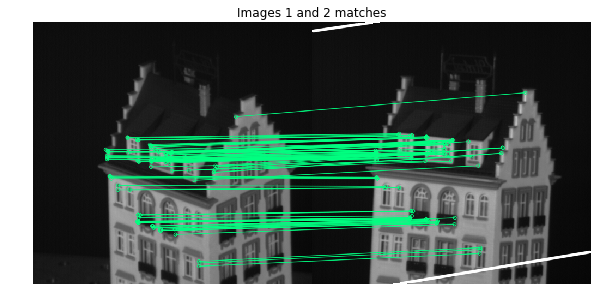

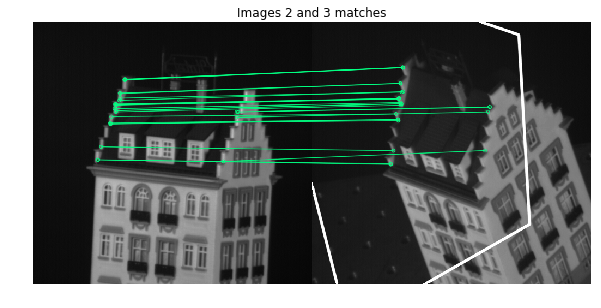

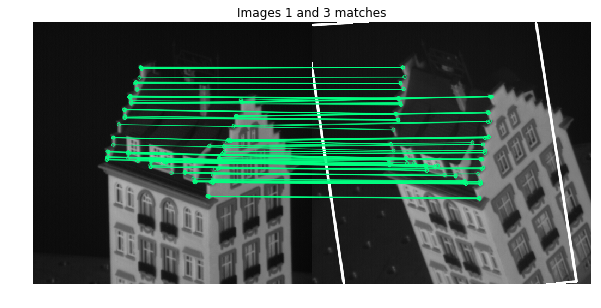

(1377, 2)
(1377, 2)
(2754, 2)
(2754, 2)
((2754, 2754), (2,), (2, 2))


In [6]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Image plot function
def plotImage(title,image):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


# ORB
def Orb_descript(imgA, imgB, title):
    orb = cv2.ORB_create()
    resultsImg = imgB.copy()
    kpA, desA = orb.detectAndCompute(imgA,None)
    kpB, desB = orb.detectAndCompute(imgB,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(desA,desB, k=2)
    good = []
    U = []
    V = []
    for m,n in matches:
        if m.distance < n.distance:
            good.append(m)
            U.append([kpA[m.trainIdx].pt[0],kpB[m.queryIdx].pt[0]])
            V.append([kpA[m.trainIdx].pt[1],kpB[m.queryIdx].pt[1]])

    src_pts = np.float32([ kpA[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpB[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = imgA.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(resultsImg,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    draw_params = dict(matchColor = (0,255,128), # draw matches in blue color
                       singlePointColor = (0,255,128),
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    img3 = cv2.drawMatches(imgA,kpA,resultsImg,kpB,good,None,**draw_params) 
    plotImage(title, img3)
    return np.array(U), np.array(V)

def centralizeW(W):
    newW = np.zeros(W.shape)
    for i in range(W.shape[0]):
        m = (W[i][0] + W[i][1])/2
        newW[i][0] = W[i][0] - m
        newW[i][1] = W[i][1] - m
    return newW;
    

img1 = cv2.imread('img1.jpg', 0)    
img2 = cv2.imread('img2.jpg', 0)
img3 = cv2.imread('img3.jpg', 0)

U1, V1 = Orb_descript(img1,img2, "Images 1 and 2 matches")
U2, V2 = Orb_descript(img2,img3, "Images 2 and 3 matches")
U3, V3 = Orb_descript(img1,img3, "Images 1 and 3 matches")

U = np.concatenate((U1, U2), axis=0)
U = np.concatenate((U, U3), axis=0)

V = np.concatenate((V1, V2), axis=0)
V = np.concatenate((V, V3), axis=0)

W = np.concatenate((U,V), axis = 0)

print(U.shape)
print(V.shape)
print(W.shape)

W = centralizeW(W);

print(W.shape)

U, s, V = np.linalg.svd(W, full_matrices=True)

print((U.shape, s.shape, V.shape))